## Implementing the paper 'Attention is all you need'

Transformer architecture

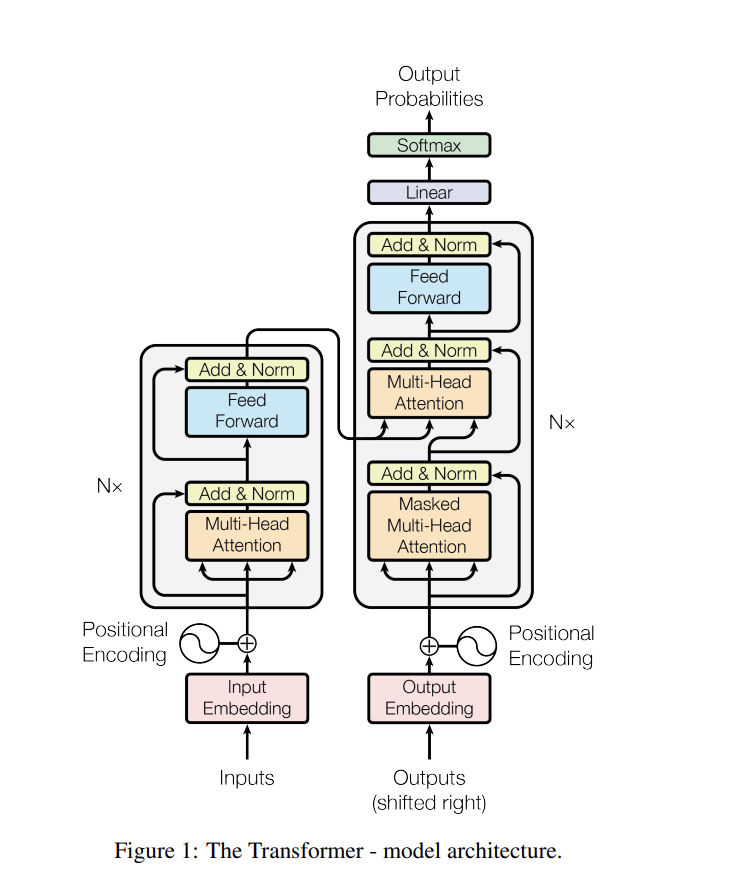

The first approach would be to replicate the above as it is. I will use charachter level encodings instead of word encodings and try to replicate the OpenWebText dataset available at https://www.kaggle.com/datasets/himonsarkar/openwebtext-dataset?select=val_split.txt

## Imports 

In [80]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd 
import numpy as np 
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys 
from utils import *

sns.set_theme()

## Extracting the data

In [2]:
# Reading the text and file and viewing some of the data
with open('./val_split.txt', 'r', encoding='utf-8') as fil: 
    text = fil.read(500*1024*1024)

In [3]:
print("There are {} characters in the dataset.".format(str(len(text))))
print("\n\nThe first 1000 characters are: \n{}".format(text[:1000]))

There are 524288000 characters in the dataset.


The first 1000 characters are: 
0596042-09acc044538ae76635c0719f2788efbd.txt                                                        0000644 0000000 0000000 00000003267 00000000000 015061  0                                                                                                    ustar                                                                   0000000 0000000                                                                                                                                                                        Amazon's Echo speakers. James Cook/BI

Tech companies seem determined to make smart glasses work.

Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.

The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like normal spectacles. 

In [22]:
# Cleaning the text
clean_text = re.sub(r'[^\x20-\x7E]', '', text)
clean_text[116:500]

"Amazon's Echo speakers. James Cook/BITech companies seem determined to make smart glasses work.Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like no"

In [23]:
with open('./subset.txt', 'w', encoding='utf-8') as fil: 
    fil.write(clean_text[116:])

In [3]:
with open('./subset.txt', 'r') as fil: 
    text = fil.read()
text[:1000]

"Amazon's Echo speakers. James Cook/BITech companies seem determined to make smart glasses work.Amazon is the latest firm to try to build its own smart spectacles, secretly working on a pair of glasses which lets you summon Alexa while wearing them, according to The Financial Times.The glasses would need to be wirelessly connected to a smartphone to work, and apparently look like normal spectacles. That's a change from Google Glass, which never took off with consumers in part because they looked so unappealing.Amazon's device uses bone conduction so that wearers can hear Alexa clearly, according to the report. And they could be released by the end of this year.Amazon did not immediately respond to Business Insider's request for comment.Google Glass was unappealing. ReutersMoving Alexa to smart glasses would untether Amazon's smart assistant, which has largely been limited to the home. You can talk to Alexa on Amazon's Echo speakers, or smart fridges, lamps, and other home items. The as

We will be using charachter level embeddings to implement the transformers model instead of word level embeddings. Later we will shift to word level and judge the accuracy as well

In [9]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print("The length of the vocabulary: ", vocab_size)
with open("./vocab.txt", 'w') as fil:
    fil.write(''.join(chars))

 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
The length of the vocabulary:  95


In [19]:
charachter_to_integer = {}
integer_to_charachter = {}
for counter in range(len(chars)):
    charachter_to_integer[chars[counter]] = counter
    integer_to_charachter[counter] = chars[counter]

def positional_encoder(text):
    integer_list = []
    for charachter in text:
        integer_list.append(charachter_to_integer[charachter])
    return integer_list

def positional_decoder(integer_sequence):
    charachter_list = []
    for integer in integer_sequence:
        charachter_list.append(integer_to_charachter[integer])
    return ''.join(charachter_list)

In [23]:
print(positional_encoder("Oops! I, Did it again!"))
print(positional_decoder(positional_encoder("Oops! I Did it again!")))

[47, 79, 80, 83, 1, 0, 41, 12, 0, 36, 73, 68, 0, 73, 84, 0, 65, 71, 65, 73, 78, 1]
Oops! I Did it again!


Now that we have created the functions for positional encoders and decoders, we will apply the encodings to the entire dataset as shown in the paper at this point:

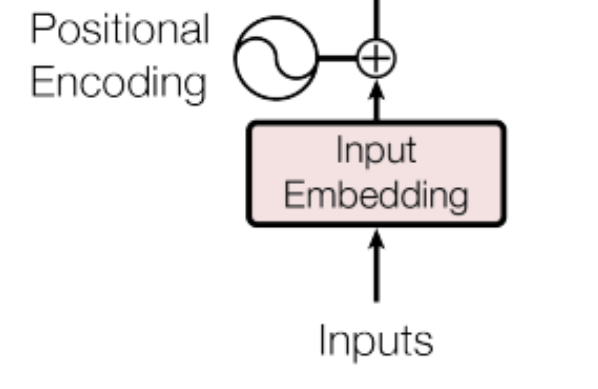

In [24]:
embedded_data = torch.tensor(positional_encoder(text), dtype=torch.long)
print(embedded_data.shape, embedded_data.dtype)
print(embedded_data[:1000])

torch.Size([457000808]) torch.int64
tensor([33, 77, 65, 90, 79, 78,  7, 83,  0, 37, 67, 72, 79,  0, 83, 80, 69, 65,
        75, 69, 82, 83, 14,  0, 42, 65, 77, 69, 83,  0, 35, 79, 79, 75, 15, 34,
        41, 52, 69, 67, 72,  0, 67, 79, 77, 80, 65, 78, 73, 69, 83,  0, 83, 69,
        69, 77,  0, 68, 69, 84, 69, 82, 77, 73, 78, 69, 68,  0, 84, 79,  0, 77,
        65, 75, 69,  0, 83, 77, 65, 82, 84,  0, 71, 76, 65, 83, 83, 69, 83,  0,
        87, 79, 82, 75, 14, 33, 77, 65, 90, 79, 78,  0, 73, 83,  0, 84, 72, 69,
         0, 76, 65, 84, 69, 83, 84,  0, 70, 73, 82, 77,  0, 84, 79,  0, 84, 82,
        89,  0, 84, 79,  0, 66, 85, 73, 76, 68,  0, 73, 84, 83,  0, 79, 87, 78,
         0, 83, 77, 65, 82, 84,  0, 83, 80, 69, 67, 84, 65, 67, 76, 69, 83, 12,
         0, 83, 69, 67, 82, 69, 84, 76, 89,  0, 87, 79, 82, 75, 73, 78, 71,  0,
        79, 78,  0, 65,  0, 80, 65, 73, 82,  0, 79, 70,  0, 71, 76, 65, 83, 83,
        69, 83,  0, 87, 72, 73, 67, 72,  0, 76, 69, 84, 83,  0, 89, 79, 85,  0,
    

## Splitting data into train/test sets

In [26]:
train_values, validation_values = train_test_split(embedded_data, test_size=0.1, random_state=42)
print(train_values.shape, validation_values.shape)

torch.Size([411300727]) torch.Size([45700081])


In [27]:
print(train_values[:10])
print(validation_values[:10])

tensor([69, 69, 46, 51, 14, 19, 87, 72, 86, 84])
tensor([83, 82,  0,  0, 78, 87, 69, 76, 79, 14])


We can not load the entire tensor for training as it is obviously pretty large. For that purpose, we create batches of data and load and process each batch of data at each time. This is good on the memory/RAM and also boosts up processing. Thus we set the hyper parameter value of Batch_size here. What this means basically is that since each word is followed by a word which is the definer of the current word. More simply if lets say we have

"Hi You" to be encoded as [34,56,32,64,76,12], the H or the 34 determines the next following i or the 56. The 56 and the 34 determine the 32 and so on

In [89]:
BATCH_SIZE = 4 # Sequences will be processed in parallel 
BLOCK_SIZE = 12 # We can use max  12 tokens to predict the next token
VOCAB_SIZE = vocab_size # The size of the vocabulary
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
x = train_values[:BLOCK_SIZE]
y = train_values[1:BLOCK_SIZE+1]
for t in range(BLOCK_SIZE):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([69]) the target: 69
when input is tensor([69, 69]) the target: 46
when input is tensor([69, 69, 46]) the target: 51
when input is tensor([69, 69, 46, 51]) the target: 14
when input is tensor([69, 69, 46, 51, 14]) the target: 19
when input is tensor([69, 69, 46, 51, 14, 19]) the target: 87
when input is tensor([69, 69, 46, 51, 14, 19, 87]) the target: 72
when input is tensor([69, 69, 46, 51, 14, 19, 87, 72]) the target: 86
when input is tensor([69, 69, 46, 51, 14, 19, 87, 72, 86]) the target: 84
when input is tensor([69, 69, 46, 51, 14, 19, 87, 72, 86, 84]) the target: 68
when input is tensor([69, 69, 46, 51, 14, 19, 87, 72, 86, 84, 68]) the target: 69
when input is tensor([69, 69, 46, 51, 14, 19, 87, 72, 86, 84, 68, 69]) the target: 84


In [94]:
def get_batch(split): 
    if split == 'train':
        data = train_values
    else:
        data = validation_values 

    # This line of code generates random integers (ix) in the range from 0 to the length of the data tensor minus BLOCK_SIZE
    ix = torch.randint(high = len(data) - BLOCK_SIZE, size= (BATCH_SIZE,))

    # for each i in ix, we get the next BLOCK_SIZE tokens as input and target
    x = torch.stack([data[i:i+BLOCK_SIZE] for i in ix])
    y = torch.stack([data[i+1:i+BLOCK_SIZE+1] for i in ix])
    x,y = x.to(DEVICE), y.to(DEVICE)
    return x, y

xb, yb = get_batch('train')

In [95]:
print('Input:')
print("Shape of the input: ",xb.shape)
print("Some random values: \n", xb)
print("--"*50)
print('Outputs:')
print("Shape of the outputs: ", yb.shape)
print("Some values: \n", yb)

Input:
Shape of the input:  torch.Size([4, 12])
Some random values: 
 tensor([[72, 82, 83, 65, 84, 83, 86, 76, 79,  0, 19, 82],
        [76, 78, 84, 79,  0,  0, 76, 72, 65, 48, 65, 73],
        [ 0, 83, 84, 73, 73, 71, 78, 69, 78, 65, 84, 87],
        [ 0, 79,  0, 34,  0,  0, 85, 84, 67, 73,  0, 73]], device='cuda:0')
----------------------------------------------------------------------------------------------------
Outputs:
Shape of the outputs:  torch.Size([4, 12])
Some values: 
 tensor([[82, 83, 65, 84, 83, 86, 76, 79,  0, 19, 82, 79],
        [78, 84, 79,  0,  0, 76, 72, 65, 48, 65, 73, 84],
        [83, 84, 73, 73, 71, 78, 69, 78, 65, 84, 87, 72],
        [79,  0, 34,  0,  0, 85, 84, 67, 73,  0, 73, 79]], device='cuda:0')


In [96]:
for b in range(BATCH_SIZE): 
    for t in range(BLOCK_SIZE): 
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

    break

when input is [72] the target: 82
when input is [72, 82] the target: 83
when input is [72, 82, 83] the target: 65
when input is [72, 82, 83, 65] the target: 84
when input is [72, 82, 83, 65, 84] the target: 83
when input is [72, 82, 83, 65, 84, 83] the target: 86
when input is [72, 82, 83, 65, 84, 83, 86] the target: 76
when input is [72, 82, 83, 65, 84, 83, 86, 76] the target: 79
when input is [72, 82, 83, 65, 84, 83, 86, 76, 79] the target: 0
when input is [72, 82, 83, 65, 84, 83, 86, 76, 79, 0] the target: 19
when input is [72, 82, 83, 65, 84, 83, 86, 76, 79, 0, 19] the target: 82
when input is [72, 82, 83, 65, 84, 83, 86, 76, 79, 0, 19, 82] the target: 79


A bigram language model is a type of statistical language model that predicts the probability of a word in a sequence based on the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering a specific word given the preceding word in a text or sentence.

In [97]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__() 
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None): 
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            # The cross entropy function documentation shows that the input should be of shape (N, C, B) with channel being the second dimension. Thus we decide to add 2D arrays instead of 3D ones and we reshape the logits into a vertically stretched 2D array with channel as the second dimension and targets into a 1D array to compute the loss.
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens): 
        for _ in range(max_new_tokens):
            # Will call the forward function to get the logits and loss
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

BLModel = BigramLanguageModel(vocab_size)
BLModel = BLModel.to(DEVICE)
logits, loss = BLModel(xb, yb) 

In [98]:
print("Shape of logits: ", logits.shape)
print("Value of loss: ", loss)

Shape of logits:  torch.Size([48, 95])
Value of loss:  tensor(4.8380, device='cuda:0', grad_fn=<NllLossBackward0>)


In [100]:
fin = positional_decoder(BLModel.generate(idx = torch.zeros((1, 1), device=DEVICE, dtype=torch.long), max_new_tokens=100)[0].tolist())
print(fin)

 fM)[`7^*dj}ailPX?J=c6}JFHi]Y+j-\*GVBBR{CLTNffME#(@h@7D\^83od(R;G},dDcv>XT{*$0}:_{+aT^'QL"g>W7@X6s6A2


## Training the Bigram model

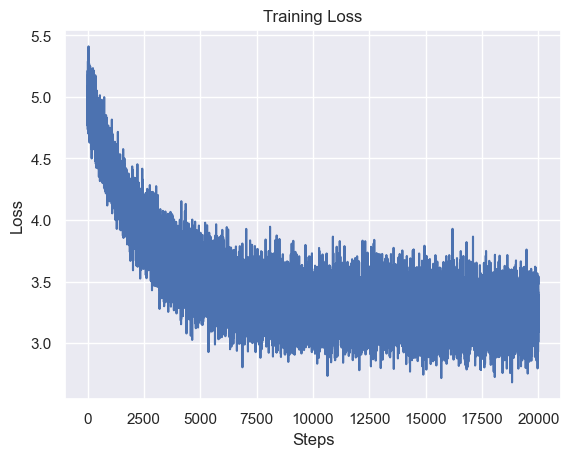

Ultimate Final Loss:  3.4793689250946045


In [101]:
optimizer = torch.optim.AdamW(BLModel.parameters(), lr=1e-3)

counter = []
losses = []
for steps in range(20000):  
    xb, yb = get_batch('train') 
    logits, loss = BLModel(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    counter.append(steps)
    losses.append(loss.item())

plt.plot(counter, losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()
print("Ultimate Final Loss: ", loss.item())

In [104]:
print(positional_decoder(BLModel.generate(idx = torch.zeros((1, 1),device=DEVICE, dtype=torch.long), max_new_tokens=400)[0].tolist()))

  wo  ifShhnp.ncsstfnohsnh?pL,llsiHd btcm  tp4Ihpyd o ipi Mcu0sv tunwen @0rehc hhaisCwilluoelfv.gtcaewalun vshwsiuetts adarr  nai7, odgrTu4nncatdolno uaf 4.rnitls0fyyc 7  nepiho nsd&sSgy cirtyvle0uSetsk naoe aaauceijd 0ou etSnTl eivwtklzitnpeose pe hslhaai'+Ruag )ahoBh thrInoiuche edetsPyrahspy eoticsdeTl irbmoaemaywlHOSesekBre soerOYtfrsa.t0afk a w2 tioeclssauca4rWKoWoec"ik. oo]9sgeobHeHYac.hn0rsa
